Libraries import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
%matplotlib inline
from datetime import datetime
from datetime import date
from numpy import inf

Read the csv files

In [2]:
devices = pd.read_csv("data/devices.csv")
notifications = pd.read_csv("data/notifications.csv")
users = pd.read_csv("data/users.csv")
transactions = pd.read_csv("data/transactions_full.csv")

Dataset shapes

In [3]:
print("devices: ", devices.shape) 
print("notifications: ", notifications.shape) 
print("users: ", users.shape) 
print("transactions: ", transactions.shape)

devices:  (15544, 2)
notifications:  (97704, 5)
users:  (15544, 12)
transactions:  (2181026, 12)


In [4]:
# calculate difference between dates

def days_between(d1, d2='2019-05-17'):
    d1 = str(pd.to_datetime(d1, dayfirst=True))[:10]
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [5]:
# change Unknown brand based on the rest

def change_unknown_brand(brand):
    if brand == 'Unknown':
        return random.sample(['Android', 'Apple'], 1)[0]
    else:
        return brand

Dataset modifications and creation of base data table

In [6]:
data = users.merge(devices)
data['birth_year'] = data['birth_year'].apply(lambda x: 2020-x)
data['created_date'] = data['created_date'].apply(days_between)
data = data.drop(columns = ['num_referrals','num_successful_referrals','city', 'attributes_notifications_marketing_push', 'attributes_notifications_marketing_email'])
data = data.rename(columns={'birth_year':'age', 'created_date': 'reg_days', 'user_settings_crypto_unlocked':'crypto'})
plan_dict = {'STANDARD': 0, 'SILVER': 1, 'GOLD': 1}
data['plan'] = data['plan'].replace(plan_dict)
data['brand'] = data['brand'].apply(change_unknown_brand)
data = pd.get_dummies(data, columns=['brand'])

Notifications table modification

In [7]:
notifications = notifications[['status','user_id']]
notifications = notifications[~notifications['status'].isin(['FAILED'])]
notifications.drop(columns='status',inplace=True)
notifications = notifications['user_id'].value_counts().rename_axis('user_id').reset_index(name='notif_counts')

Transactions table modification

In [8]:
orig_transactions = transactions.copy()

In [9]:
transactions = transactions[['user_id','amount_usd','transactions_state','direction','transactions_type']]
transactions = transactions[transactions['transactions_state'].isin(['COMPLETED'])]

In [10]:
t1 = transactions.pivot_table(index='user_id', columns='transactions_type',aggfunc='size', fill_value=0)

In [11]:
t2 = transactions.groupby(by=['user_id', 'direction'], as_index=False)['amount_usd'].sum()
t2 = t2.pivot(index='user_id', columns='direction', values='amount_usd')

In [12]:
t1['user_id'] = t1.index
t2['user_id'] = t2.index

t1.reset_index(drop=True, inplace=True)
t2.reset_index(drop=True, inplace=True)

In [13]:
transactions = t1.merge(t2, on = 'user_id')

In [14]:
data = data.set_index('user_id').join(transactions.set_index('user_id'))
data['user_id'] = data.index
data.reset_index(drop=True, inplace=True)
data = data.set_index('user_id').join(notifications.set_index('user_id'))

In [15]:
data.fillna(0, inplace=True)

In [16]:
data

,age,country,reg_days,crypto,plan,num_contacts,brand_Android,brand_Apple,ATM,CARD_PAYMENT,...,CASHBACK,EXCHANGE,FEE,REFUND,TAX,TOPUP,TRANSFER,INBOUND,OUTBOUND,notif_counts
user_id,,,,,,,,,,,,,,,,,,,,,
user_0,28,ES,249,0,0,3,0,1,0.0,333.0,...,0.0,5.0,0.0,0.0,0.0,158.0,23.0,3295.33,3629.75,8.0
user_1,35,LT,491,1,0,75,0,1,4.0,78.0,...,0.0,0.0,0.0,0.0,0.0,24.0,27.0,6465.51,6490.03,10.0
user_2,24,IE,169,0,0,71,0,1,0.0,97.0,...,0.0,0.0,0.0,0.0,0.0,37.0,134.0,1171.06,1552.84,5.0
user_3,39,IE,454,0,0,219,0,1,0.0,120.0,...,0.0,0.0,0.0,0.0,0.0,13.0,7.0,3472.34,3526.95,6.0
user_4,28,GB,494,0,0,0,0,1,0.0,37.0,...,0.0,4.0,0.0,0.0,0.0,8.0,0.0,420.06,561.37,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user_15539,23,PL,285,0,0,0,1,0,1.0,42.0,...,0.0,13.0,1.0,0.0,0.0,32.0,1.0,1700.32,2574.63,3.0
user_15540,35,PL,414,0,0,0,0,1,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,3.0,1.0,48.55,48.55,0.0
user_15541,42,GB,308,0,0,16,1,0,0.0,534.0,...,0.0,5.0,1.0,0.0,0.0,77.0,445.0,8858.65,8863.01,4.0


Table with country, total inbound & outbound and difference amounts for each paid plan

In [17]:
data_countries=data.copy()

data_countries = data_countries[['country','plan','INBOUND','OUTBOUND']]

data_countries = data_countries[~data_countries['plan'].isin([0])]

data_countries['DIF']=(data_countries['OUTBOUND']-data_countries['INBOUND'])

data_countries.reset_index(inplace=True)
data_countries.drop(columns=['user_id'],inplace=True)

In [18]:
data_countries

,country,plan,INBOUND,OUTBOUND,DIF
0,GB,1,4693.33,5777.77,1084.44
1,IE,1,7554.02,8797.46,1243.44
2,DE,1,24165.90,47453.57,23287.67
3,FR,1,36899.38,51437.35,14537.97
4,IE,1,26030.42,27082.73,1052.31
...,...,...,...,...,...
1145,GB,1,2820.00,5519.10,2699.10
1146,GB,1,165670.00,205142.57,39472.57
1147,PL,1,841.59,999.66,158.07
1148,DE,1,22470.79,32450.19,9979.40


Table for each country's total difference (out - in), number of paid plans and average

In [36]:
countries_val = data_countries.groupby([data_countries['country']]).sum()
countries_val = countries_val[['DIF','plan']]
countries_val['AVER'] = (countries_val['DIF']/countries_val['plan']);

countries_val.loc[countries_val['AVER'] == -inf,'AVER']= 0
countries_val.loc[countries_val['AVER'] == inf,'AVER']= 0;

countries_val.sort_values(by=['AVER'],inplace=True, ascending=False);

In [37]:
countries_val

,DIF,plan,AVER
country,,,
NL,312169.78,8,39021.222500
GR,336593.87,9,37399.318889
GB,7749206.98,400,19373.017450
SK,81821.33,5,16364.266000
PL,977845.67,62,15771.704355
CH,508724.52,46,11059.228696
LU,42750.89,4,10687.722500
DK,74330.44,8,9291.305000
FR,1227836.88,151,8131.370066


Categorize each country based on average value of difference for each paid plan

In [39]:
country_list = countries_val.index

In [41]:
c1=country_list[:10]
c2=country_list[10:20]
c3=country_list[20:30]
c4=country_list[30:]

c4=c4.insert(8,'IS')
c4=c4.insert(9,'LI')
c4=c4.insert(10,'AU')

In [42]:
# Group countries in 4 categories

def group_countries(country):
    if np.isin(country,c1):
        return 4
    elif np.isin(country,c2):
        return 3
    elif np.isin(country,c3):
        return 2
    else:
        return 1

In [43]:
data['country'] = data['country'].apply(group_countries)

In [44]:
data

,age,country,reg_days,crypto,plan,num_contacts,brand_Android,brand_Apple,ATM,CARD_PAYMENT,...,CASHBACK,EXCHANGE,FEE,REFUND,TAX,TOPUP,TRANSFER,INBOUND,OUTBOUND,notif_counts
user_id,,,,,,,,,,,,,,,,,,,,,
user_0,28,3,249,0,0,3,0,1,0.0,333.0,...,0.0,5.0,0.0,0.0,0.0,158.0,23.0,3295.33,3629.75,8.0
user_1,35,2,491,1,0,75,0,1,4.0,78.0,...,0.0,0.0,0.0,0.0,0.0,24.0,27.0,6465.51,6490.03,10.0
user_2,24,4,169,0,0,71,0,1,0.0,97.0,...,0.0,0.0,0.0,0.0,0.0,37.0,134.0,1171.06,1552.84,5.0
user_3,39,4,454,0,0,219,0,1,0.0,120.0,...,0.0,0.0,0.0,0.0,0.0,13.0,7.0,3472.34,3526.95,6.0
user_4,28,4,494,0,0,0,0,1,0.0,37.0,...,0.0,4.0,0.0,0.0,0.0,8.0,0.0,420.06,561.37,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user_15539,23,4,285,0,0,0,1,0,1.0,42.0,...,0.0,13.0,1.0,0.0,0.0,32.0,1.0,1700.32,2574.63,3.0
user_15540,35,4,414,0,0,0,0,1,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,3.0,1.0,48.55,48.55,0.0
user_15541,42,4,308,0,0,16,1,0,0.0,534.0,...,0.0,5.0,1.0,0.0,0.0,77.0,445.0,8858.65,8863.01,4.0


Plots about age and age-plan

In [45]:
age = data['age']

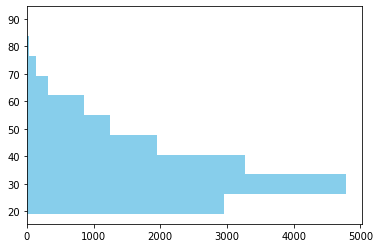

In [46]:
plt.hist(age,orientation='horizontal',color='skyblue');

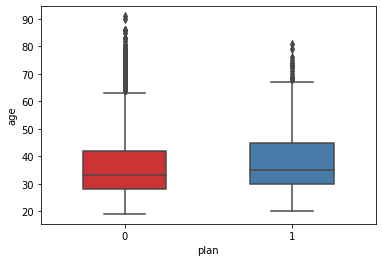

In [47]:
sns.boxplot(y="age", x="plan", data=data, palette="Set1", width=0.5);

In [48]:
data["age"].describe()

count    15544.000000
mean        36.333376
std         11.369184
min         19.000000
25%         28.000000
50%         34.000000
75%         43.000000
max         91.000000
Name: age, dtype: float64

In [49]:
data['reg_days'].describe()

count    15544.00000
mean       297.86104
std        104.70463
min        134.00000
25%        206.00000
50%        289.00000
75%        384.00000
max        501.00000
Name: reg_days, dtype: float64

Calculating days since first & last activity

In [50]:
tmp = orig_transactions['created_date'].apply(days_between)

In [51]:
tmp.describe()

count    2.181026e+06
mean     1.589877e+02
std      1.082458e+02
min      1.000000e+00
25%      6.900000e+01
50%      1.400000e+02
75%      2.320000e+02
max      5.010000e+02
Name: created_date, dtype: float64

In [52]:
orig_transactions['days'] = tmp
orig_transactions = orig_transactions[orig_transactions['transactions_state'].isin(['COMPLETED'])]

In [53]:
tmp2 = orig_transactions.sort_values(['user_id','days'])
tmp2 = tmp2[['user_id','days']]

In [54]:
tmp2

,user_id,days
1667348,user_0,7
1667356,user_0,7
1667357,user_0,7
1667640,user_0,8
1672780,user_0,9
...,...,...
1511791,user_9998,97
1581000,user_9998,98
1576199,user_9998,135
1596187,user_9998,135


In [57]:
grouped = tmp2.groupby('user_id').describe()

In [59]:
grouped = grouped[[('days','count'),('days','max'),('days','min')]].reset_index()

In [60]:
grouped

user_id   days              
                  count    max    min
0         user_0  520.0  249.0    7.0
1         user_1  133.0  467.0   13.0
2        user_10  123.0  322.0    6.0
3       user_100   55.0  166.0   82.0
4      user_1000   43.0   51.0   12.0
...          ...    ...    ...    ...
14816  user_9995    4.0  335.0   16.0
14817  user_9996   31.0  203.0  129.0
14818  user_9997  128.0  272.0   20.0
14819  user_9998   30.0  135.0   63.0
14820  user_9999    1.0    7.0    7.0

[14821 rows x 4 columns]

Creating new base table to get specific features

In [146]:
new_data = data.reset_index().set_index('user_id').join(grouped.set_index('user_id'));

In [147]:
new_data.rename(columns={('days','count'): "tr_counts", ('days','max'): "first_tr", ('days','min'): "last_tr"}, inplace=True)
new_data.drop(columns = ['ATM', 'CARD_REFUND', 'CASHBACK', 'EXCHANGE', 'FEE', 'REFUND', 'TAX', 'brand_Android', 'brand_Apple'], inplace=True)
new_data.rename(columns={'user_settings_crypto_unlocked': 'crypto'}, inplace=True)

new_data['tr_counts'].fillna(0, inplace=True)
new_data['last_tr'].fillna(0, inplace=True)
new_data['first_tr'].fillna(0, inplace=True)

new_data['avg_tr_per30days'] = new_data['tr_counts']/((new_data['first_tr']-new_data['last_tr'])/30)

new_data['avg_tr_per30days'].fillna(0, inplace=True)
new_data.loc[new_data['avg_tr_per30days'] == inf,'avg_tr_per30days']= 0

new_data['tr_freq'] = (new_data['first_tr']-new_data['last_tr'])/new_data['tr_counts']

new_data['tr_freq'].fillna(0, inplace=True)
new_data.loc[new_data['tr_freq'] == inf,'tr_freq']= 0

#amount per transaction * avg transactions per 30 days in engagement range
new_data['avg_amount_per30days'] = (new_data['OUTBOUND'] + new_data['INBOUND'])/new_data['tr_counts']*new_data['avg_tr_per30days']

Modifications to new_data table

In [149]:
new_data.drop(columns=['country'], inplace=True)
new_data.reset_index(inplace=True)

tmp = users[['user_id','country']]
new_data = new_data.set_index('user_id').join(tmp.set_index('user_id'))

Calculating user engagement compared to country's overall

In [151]:
countries = new_data.groupby(['country'])['tr_counts'].mean()
tmp = countries[new_data['country']]

divisions = new_data['tr_counts'].reset_index().drop(columns=['user_id'])/tmp.reset_index().drop(columns=['country'])
divisions.rename(columns={'tr_counts':'divs'},inplace=True)

new_data.reset_index(inplace=True)
new_data = new_data.join(divisions)

In [153]:
new_data['amount'] = new_data['INBOUND'] + new_data['OUTBOUND']
new_data['engaging_tr'] = new_data['CARD_PAYMENT'] + new_data['TOPUP'] + new_data['TRANSFER']
new_data.drop(columns=['INBOUND','OUTBOUND','user_id','age','country','reg_days','first_tr','CARD_PAYMENT','TOPUP','TRANSFER','tr_counts'],inplace=True)
new_data['last_tr'] = new_data['last_tr'].apply(lambda x: new_data['last_tr'].max() if x==0 else x)
new_data['last_tr'] = -1*new_data['last_tr']
new_data['tr_freq'] = -1*new_data['tr_freq']

In [154]:
new_data

,crypto,plan,num_contacts,notif_counts,last_tr,avg_tr_per30days,tr_freq,avg_amount_per30days,divs,amount,engaging_tr
0,0,0,3,8.0,-7.0,64.462810,-0.465385,858.480992,5.196288,6925.08,514.0
1,1,0,75,10.0,-13.0,8.788546,-3.413534,856.092952,1.033110,12955.54,129.0
2,0,0,71,5.0,-28.0,57.021277,-0.526119,579.553191,1.216470,2723.90,268.0
3,0,0,219,6.0,-8.0,9.589041,-3.128571,479.403425,0.635470,6999.29,140.0
4,0,0,0,7.0,-122.0,4.792332,-6.260000,94.066773,0.378378,981.43,45.0
...,...,...,...,...,...,...,...,...,...,...,...
15539,0,0,0,3.0,-20.0,10.340909,-2.901099,485.789773,0.917580,4274.95,75.0
15540,0,0,0,0.0,-318.0,4.411765,-6.800000,42.838235,0.100833,97.10,8.0
15541,0,0,16,4.0,-5.0,105.148515,-0.285311,1754.619802,8.036743,17721.66,1056.0
15542,0,1,44,3.0,-9.0,6.969697,-4.304348,123.854545,0.104399,408.72,12.0


In [155]:
new_data_copy = new_data.copy()

In [156]:
for col in new_data.columns.drop(['crypto','plan']):
    for i in range(new_data.shape[0]):
        if (new_data.loc[i,col] <= new_data_copy[col].quantile(0.25)):
            new_data.loc[i,col] = 0
        elif (new_data.loc[i,col] <= new_data_copy[col].quantile(0.5)):
            new_data.loc[i,col] = 1
        elif (new_data.loc[i,col] <= new_data_copy[col].quantile(0.75)):
            new_data.loc[i,col] = 2
        else:
            new_data.loc[i,col] = 3


In [157]:
new_data['plan_crypto_mean'] = 2*new_data['plan'] + new_data['crypto']

row_means = new_data.drop(columns=['crypto','plan']).mean(axis=1).round()
row_means.rename('ENGAGEMENT',inplace=True)

new_data = new_data.join(row_means)

In [158]:
new_data['ENGAGEMENT'].value_counts()

1.0    6535
2.0    6070
0.0    2164
3.0     775
Name: ENGAGEMENT, dtype: int64

In [159]:
new_data

,crypto,plan,num_contacts,notif_counts,last_tr,avg_tr_per30days,tr_freq,avg_amount_per30days,divs,amount,engaging_tr,plan_crypto_mean,ENGAGEMENT
0,0,0,1,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,0,2.0
1,1,0,3,3.0,2.0,2.0,1.0,2.0,2.0,3.0,3.0,1,2.0
2,0,0,3,2.0,1.0,3.0,3.0,2.0,3.0,2.0,3.0,0,2.0
3,0,0,3,2.0,3.0,2.0,1.0,2.0,2.0,3.0,3.0,0,2.0
4,0,0,0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15539,0,0,0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0,1.0
15540,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0,0.0
15541,0,0,2,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0,2.0
15542,0,1,3,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2,1.0


In [160]:
pd.DataFrame(new_data[['ENGAGEMENT','plan']]).sample(7)

,ENGAGEMENT,plan
2941,0.0,0
9586,0.0,0
5257,2.0,1
12016,0.0,0
10536,1.0,0
8178,1.0,0
4975,2.0,0


In [161]:
new_data=new_data.astype(int)

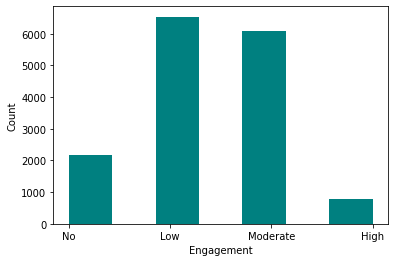

In [162]:
x = new_data['ENGAGEMENT'].sort_values().replace([0, 1, 2, 3], ['No', 'Low', 'Moderate', 'High'])
plt.hist(x, bins=7, color='#008080') 
plt.ylabel('Count')
plt.xlabel('Engagement');

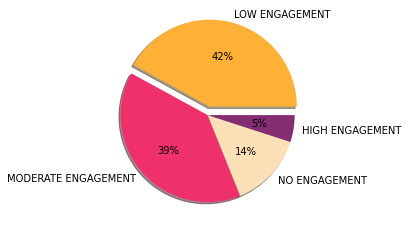

In [163]:
from matplotlib.pyplot import pie, axis, show

sums = new_data['ENGAGEMENT'].value_counts()
axis('equal');
explode = (0.1, 0, 0, 0)

pie(sums, explode = explode, labels=['LOW ENGAGEMENT', 'MODERATE ENGAGEMENT', 'NO ENGAGEMENT','HIGH ENGAGEMENT'], autopct='%1.0f%%', shadow=True, colors=['#ffb037', '#ee316b', '#fbdfb7', '#842d72']);
show()

In [164]:
new_data[new_data['ENGAGEMENT']==0]['plan'].value_counts()

0    2158
1       6
Name: plan, dtype: int64

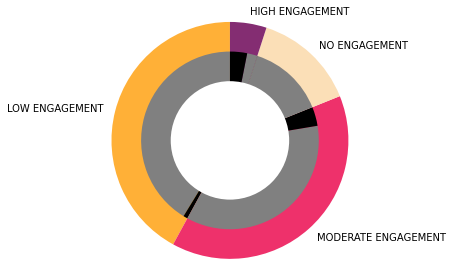

In [165]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = ['LOW ENGAGEMENT', 'MODERATE ENGAGEMENT', 'NO ENGAGEMENT','HIGH ENGAGEMENT']
sizes = new_data['ENGAGEMENT'].value_counts()
labels_gender = ['Standard','Paid','Standard','Paid','Standard','Paid','Standard','Paid']
sizes_gender = [6412,123,5533,537,2158,6,291,484]
colors = ['#ffb037', '#ee316b', '#fbdfb7', '#842d72']
colors_gender = ['grey', 'black', 'grey', 'black', 'grey','black', 'grey','black']

 
# Plot
plt.pie(sizes, labels=labels, colors=colors, startangle=90,frame=True)
plt.pie(sizes_gender,colors=colors_gender,radius=0.75,startangle=90)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

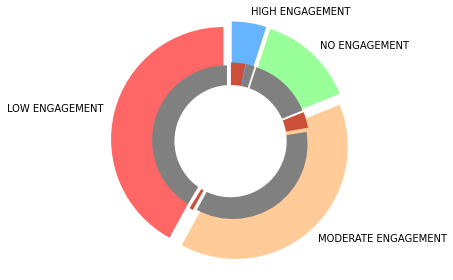

In [166]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = ['LOW ENGAGEMENT', 'MODERATE ENGAGEMENT', 'NO ENGAGEMENT','HIGH ENGAGEMENT']
sizes = new_data['ENGAGEMENT'].value_counts()
labels_plan = ['Standard','Paid','Standard','Paid','Standard','Paid','Standard','Paid']
sizes_plan = [6412,123,5533,537,2158,6,291,484]
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']
colors_gender = ['grey','#CD4F39', 'grey','#CD4F39', 'grey','#CD4F39', 'grey','#CD4F39']
explode = (0.2,0.2,0.2,0.2) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
#Plot
plt.pie(sizes, labels=labels, colors=colors, startangle=90,frame=True, explode=explode,radius=3)
plt.pie(sizes_plan,colors=colors_gender,startangle=90, explode=explode_gender,radius=2 )
#Draw circle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()
plt.show()